<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/liskeenanFen_s_w_DSM_4_slope_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#unzip
!unzip -q "/content/drive/MyDrive/liskeenanfen.zip" -d "/content/dataset"

In [3]:
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
S_RGB_PATH = '/content/dataset/liskeenanfen/liskeenanfen/liskeenan_ortho_summer.tif'
S_NDVI_PATH = '/content/dataset/liskeenanfen/liskeenanfen/Liskeenanfen_Summer_NDVI.tif'

W_RGB_PATH = '/content/dataset/liskeenanfen/liskeenanfen/Liskeenanfen_Winter_RGB.tif'
W_NDVI_PATH = '/content/dataset/liskeenanfen/liskeenanfen/Liskeenanfen_Winter_NDVI.tif'

SHP_PATH = '/content/dataset/liskeenanfen/liskeenanfen/Liskeenanfen_habimap.shp'

In [5]:
gdf = gpd.read_file(SHP_PATH)
if 'HABITAT' in gdf.columns:
    print(gdf['HABITAT'].unique())
elif 'label' in gdf.columns:
    print(gdf['label'].unique())
else:
    print("No 'HABITAT' or 'label' column found. Available columns:")
    print(gdf.columns.tolist())

No 'HABITAT' or 'label' column found. Available columns:
['fid', 'FEN_ID', 'FEN_NAME', 'SITECODE', 'AREA_m2', 'NOTES_PRE', 'NOTES_POST', 'SURVEYOR', 'NON_HDH', '7140', '7210', '7230', '3180', '4010', '6211', '6410', '6430', '7110', '7130', '91D0', '91E0', 'PCENT_HDH', 'ED2', 'ED3', 'FL3', 'FL6', 'FL8', 'FS1', 'FS2', 'FW2', 'FW4', 'GA1', 'GM1', 'GS1', 'GS2', 'GS4', 'HD1', 'HH3', 'PB1', 'PB4', 'PF1', 'PF2', 'PF3', 'WD1', 'WD2', 'WD3', 'WD4', 'WL1', 'WL2', 'WN2', 'WN6', 'WN7', 'WS1', 'NON_HDH_PF', 'HDH_MAPPED', 'HCH_MAPPED', 'FE1', 'FE1A', 'FE1B', 'FE2', 'FE2A', 'FE2C', 'FE2D', 'FE2F', 'FE3', 'FE3A', 'FE3B', 'FE3D', 'FW3', 'FW3C', 'FW3G', 'FW3H', 'GL1', 'GL1D', 'HE4C', 'HE4D', 'JUNC_SUBNO', 'geometry']


In [6]:
LABEL_COL = 'fid'
NAME_COL = 'HCH_MAPPED'

gdf = gpd.read_file(SHP_PATH)

In [28]:
fossitt_merger = {
    'GS4' : 'grassland',
    'GS4/GS1' : 'grassland',
    'PF1/GS4' : 'grassland',
    'FL6' : 'grassland',
    'GS1' : 'grassland',
    'PF1' : 'grassland',

    'PF3': 'peatland',
    'PB1': 'peatland',
    'PF3' : 'peatland',
    'HH3': 'peatland',


    'WN6': 'Tree & scrub',
    'WN7': 'Tree & scrub',
    'WS1': 'Tree & scrub',
    'WD3': 'Tree & scrub',
    'WL2': 'Tree & scrub',

    'FS1': 'swamp'

}
gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

In [29]:
all_pixels, all_labels = [], []

# --- 2. COORDINATED EXTRACTION ---
# Open all 4 sources
with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(W_RGB_PATH) as wr, rasterio.open(W_NDVI_PATH) as wn:

    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

    print("Extracting 11 seasonal features...")
    for idx, row in gdf.iterrows():
        try:
            poly = row.geometry
            min_x, min_y, max_x, max_y = poly.bounds
            points = []
            for _ in range(1000):
                pt = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
                if Point(pt).within(poly): points.append(pt)
                if len(points) >= 1000: break

            if not points: continue

            # Sample all 4 rasters
            s_rgb_vals = np.array(list(sr.sample(points))).astype('float32')
            s_ndvi_vals = np.array(list(sn.sample(points))).astype('float32')
            w_rgb_vals = np.array(list(wr.sample(points))).astype('float32')
            w_ndvi_vals = np.array(list(wn.sample(points))).astype('float32')

            # Feature Engineering
            # 1-6: Summer RGB + Winter RGB
            # 7-8: Summer NDVI + Winter NDVI
            # 9-10: Summer VARI + Winter VARI (Calculated from RGB)
            s_vari = (s_rgb_vals[:,1]-s_rgb_vals[:,0]) / (s_rgb_vals[:,1]+s_rgb_vals[:,0]-s_rgb_vals[:,2]+1e-5)
            w_vari = (w_rgb_vals[:,1]-w_rgb_vals[:,0]) / (w_rgb_vals[:,1]+w_rgb_vals[:,0]-w_rgb_vals[:,2]+1e-5)
            # 11: Delta NDVI (Seasonality change)
            delta_ndvi = s_ndvi_vals - w_ndvi_vals

            combined = np.column_stack([
                s_rgb_vals, w_rgb_vals,
                s_ndvi_vals, w_ndvi_vals,
                s_vari, w_vari,
                delta_ndvi
            ])

            valid = np.any(s_rgb_vals > 0, axis=1)
            if np.any(valid):
                all_pixels.append(combined[valid])
                all_labels.extend([row['merged_name']] * np.sum(valid))
        except: continue

X, y = np.vstack(all_pixels), np.array(all_labels)

Extracting 11 seasonal features...


In [30]:
print(f"Total training samples: {len(X)}")

Total training samples: 12408


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print("\n--- Final Multi-Source Seasonal Report ---")
print(classification_report(y_test, rf.predict(X_test)))


--- Final Multi-Source Seasonal Report ---
              precision    recall  f1-score   support

Tree & scrub       0.70      0.63      0.66       933
   grassland       0.84      0.90      0.87      1943
    peatland       0.63      0.62      0.63       649
       swamp       0.57      0.50      0.53       198

    accuracy                           0.76      3723
   macro avg       0.69      0.66      0.67      3723
weighted avg       0.75      0.76      0.76      3723



In [32]:
import numpy as np
from scipy import ndimage

In [33]:
S_DSM = '/content/dataset/liskeenanfen/liskeenanfen/liskeenan_dem_summer.tif'
W_DSM = '/content/dataset/liskeenanfen/liskeenanfen/Liskeenanfen_Winter_DSM.tif'

In [34]:
import rasterio

# Check CRS of all files
with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_DSM) as sd:
    print(f"Summer RGB CRS: {sr.crs}")
    print(f"Summer DSM CRS: {sd.crs}")
    gdf = gpd.read_file(SHP_PATH)
    print(f"Shapefile CRS:  {gdf.crs}")

# If they don't match, we must reproject the Shapefile to match the Raster
gdf = gdf.to_crs(sr.crs)

Summer RGB CRS: EPSG:2157
Summer DSM CRS: EPSG:2157
Shapefile CRS:  EPSG:2157


In [35]:
def get_random_points(poly, num_points):
    points = []
    min_x, min_y, max_x, max_y = poly.bounds
    for _ in range(num_points * 3): # 3x attempts to find points within poly
        pt = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if Point(pt).within(poly):
            points.append(pt)
        if len(points) >= num_points:
            break
    return points

In [36]:
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, rasterio.open(S_DSM) as sd, \
     rasterio.open(W_RGB_PATH) as wr, rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

    print("Extracting 14 Seasonal + Height features...")
    for idx, row in gdf.iterrows():
        pts = get_random_points(row.geometry, 1000)
        if not pts: continue

        # Sample all 6 rasters at point locations
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        s_nd  = np.array(list(sn.sample(pts))).astype('float32').flatten()
        w_rgb = np.array(list(wr.sample(pts))).astype('float32')
        w_nd  = np.array(list(wn.sample(pts))).astype('float32').flatten()
        s_h   = np.array(list(sd.sample(pts))).astype('float32').flatten()
        w_h   = np.array(list(wd.sample(pts))).astype('float32').flatten()

        # Feature Engineering
        s_vari = (s_rgb[:,1]-s_rgb[:,0]) / (s_rgb[:,1]+s_rgb[:,0]-s_rgb[:,2]+1e-5)
        w_vari = (w_rgb[:,1]-w_rgb[:,0]) / (w_rgb[:,1]+w_rgb[:,0]-w_rgb[:,2]+1e-5)

        # Combine into 14-column stack
        combined = np.column_stack([
            s_rgb, w_rgb,          # 1-6
            s_nd, w_nd,            # 7-8
            s_vari, w_vari,        # 9-10
            (s_nd - w_nd),         # 11: Delta NDVI
            s_h, w_h,              # 12-13
            (s_h - w_h)            # 14: Delta Height
        ])

        # Filter: Ensure Summer RGB is not black
        valid_mask = np.any(s_rgb > 0, axis=1)
        valid_pixels = combined[valid_mask]
        num_valid = valid_pixels.shape[0]

        if num_valid > 0:
            all_pixels.append(valid_pixels)
            all_labels.extend([row['merged_name']] * num_valid)

X = np.vstack(all_pixels)
y = np.array(all_labels)
print(f"Final Data Sync: X={X.shape}, y={y.shape}")

Extracting 14 Seasonal + Height features...
Final Data Sync: X=(28822, 14), y=(28822,)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [38]:
rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=700, n_jobs=-1,
                       random_state=42)

In [39]:
y_pred = rf.predict(X_test)
print("\n--- FINAL 14-FEATURE REPORT ---")
print(classification_report(y_test, y_pred))


--- FINAL 14-FEATURE REPORT ---
              precision    recall  f1-score   support

Tree & scrub       0.85      0.89      0.87      2252
   grassland       0.91      0.94      0.92      4447
    peatland       0.77      0.69      0.73      1399
       swamp       0.76      0.63      0.69       549

    accuracy                           0.86      8647
   macro avg       0.82      0.79      0.80      8647
weighted avg       0.86      0.86      0.86      8647



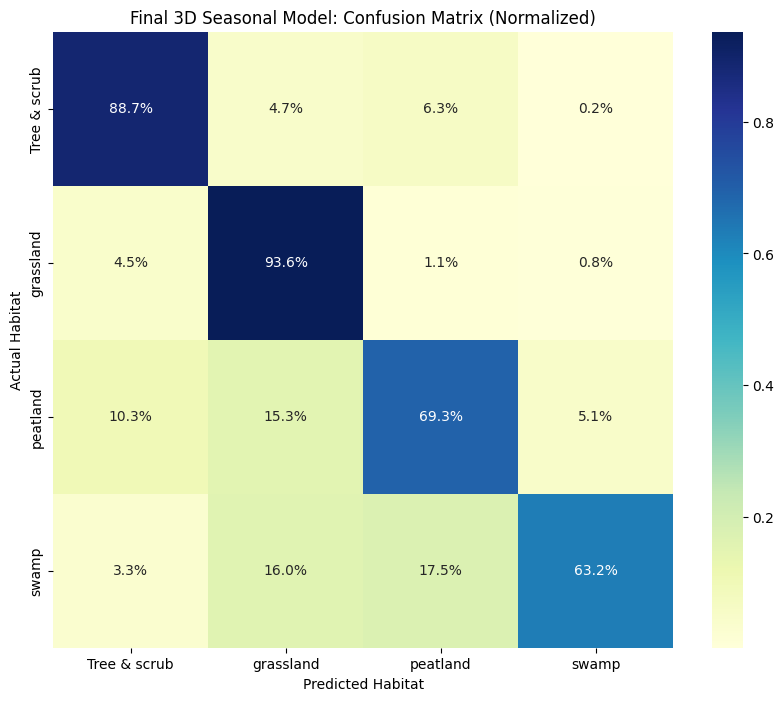

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Get the unique classes from your cleaned y_test to ensure labels match
# This prevents errors if some rare classes were merged out
labels = np.unique(y_test)

# 2. Generate the predictions
y_pred = rf.predict(X_test)

# 3. Create the matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# 4. Convert to percentages (Normalized)
# We add a tiny epsilon (1e-9) to avoid division by zero if a class is empty
cm_percent = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

# 5. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title('Final 3D Seasonal Model: Confusion Matrix (Normalized)')
plt.xlabel('Predicted Habitat')
plt.ylabel('Actual Habitat')
plt.show()

In [41]:
#slope
def calculate_local_slope(window, res=1.0):
    """Calculates slope in degrees from a 3x3 elevation window."""
    # Horn's method for slope
    dz_dx = ((window[0,2] + 2*window[1,2] + window[2,2]) -
             (window[0,0] + 2*window[1,0] + window[2,0])) / (8 * res)
    dz_dy = ((window[2,0] + 2*window[2,1] + window[2,2]) -
             (window[0,0] + 2*window[0,1] + window[0,2])) / (8 * res)

    slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    return np.degrees(slope_rad)

In [42]:
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, rasterio.open(S_DSM) as sd, \
     rasterio.open(W_RGB_PATH) as wr, rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    RES = sd.res[0] # Get resolution for slope calc (likely 1.0 or 0.5)
    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

    print("Extracting 16 Features (Seasonal + Height + Slope)...")
    for idx, row in gdf.iterrows():
        pts = get_random_points(row.geometry, 1000)
        if not pts: continue

        # Standard sampling
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        s_nd  = np.array(list(sn.sample(pts))).astype('float32').flatten()
        w_rgb = np.array(list(wr.sample(pts))).astype('float32')
        w_nd  = np.array(list(wn.sample(pts))).astype('float32').flatten()
        s_h   = np.array(list(sd.sample(pts))).astype('float32').flatten()
        w_h   = np.array(list(wd.sample(pts))).astype('float32').flatten()

        # Slope Sampling (requires reading a small window around each point)
        s_slopes, w_slopes = [], []
        for pt in pts:
            # Get pixel coordinates for the DSMs
            row_idx, col_idx = sd.index(pt[0], pt[1])
            # Read 3x3 window
            win = rasterio.windows.Window(col_idx - 1, row_idx - 1, 3, 3)

            s_win = sd.read(1, window=win, boundless=True, fill_value=0)
            w_win = wd.read(1, window=win, boundless=True, fill_value=0)

            s_slopes.append(calculate_local_slope(s_win, RES))
            w_slopes.append(calculate_local_slope(w_win, RES))

        # Feature Engineering
        s_vari = (s_rgb[:,1]-s_rgb[:,0]) / (s_rgb[:,1]+s_rgb[:,0]-s_rgb[:,2]+1e-5)
        w_vari = (w_rgb[:,1]-w_rgb[:,0]) / (w_rgb[:,1]+w_rgb[:,0]-w_rgb[:,2]+1e-5)

        # 16-column stack
        combined = np.column_stack([
            s_rgb, w_rgb,          # 1-6
            s_nd, w_nd,            # 7-8
            s_vari, w_vari,        # 9-10
            (s_nd - w_nd),         # 11: Delta NDVI
            s_h, w_h,              # 12-13
            (s_h - w_h),           # 14: Delta Height
            s_slopes, w_slopes     # 15-16: Slope layers
        ])

        valid_mask = np.any(s_rgb > 0, axis=1)
        valid_pixels = combined[valid_mask]
        if valid_pixels.shape[0] > 0:
            all_pixels.append(valid_pixels)
            all_labels.extend([row['merged_name']] * valid_pixels.shape[0])

X = np.vstack(all_pixels)
y = np.array(all_labels)
print(f"Extraction Complete: X={X.shape}")

Extracting 16 Features (Seasonal + Height + Slope)...
Extraction Complete: X=(28805, 16)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [44]:
rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=700, n_jobs=-1,
                       random_state=42)

In [45]:
y_pred = rf.predict(X_test)
print("\n--- FINAL 16-FEATURE REPORT ---")
print(classification_report(y_test, y_pred))


--- FINAL 16-FEATURE REPORT ---
              precision    recall  f1-score   support

Tree & scrub       0.86      0.90      0.88      2251
   grassland       0.93      0.94      0.94      4460
    peatland       0.81      0.74      0.77      1402
       swamp       0.78      0.72      0.75       529

    accuracy                           0.89      8642
   macro avg       0.84      0.83      0.83      8642
weighted avg       0.88      0.89      0.88      8642



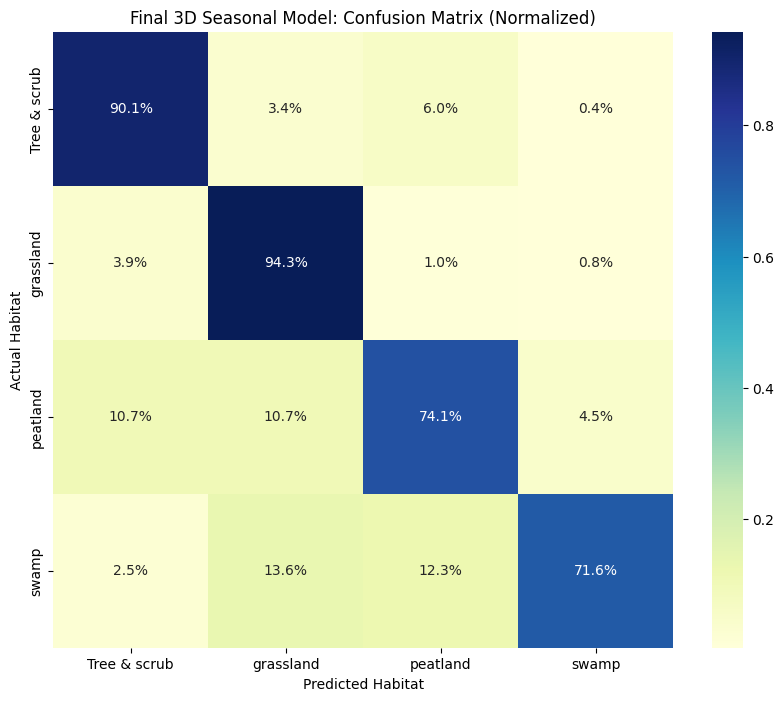

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Get the unique classes from your cleaned y_test to ensure labels match
# This prevents errors if some rare classes were merged out
labels = np.unique(y_test)

# 2. Generate the predictions
y_pred = rf.predict(X_test)

# 3. Create the matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# 4. Convert to percentages (Normalized)
# We add a tiny epsilon (1e-9) to avoid division by zero if a class is empty
cm_percent = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

# 5. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title('Final 3D Seasonal Model: Confusion Matrix (Normalized)')
plt.xlabel('Predicted Habitat')
plt.ylabel('Actual Habitat')
plt.show()

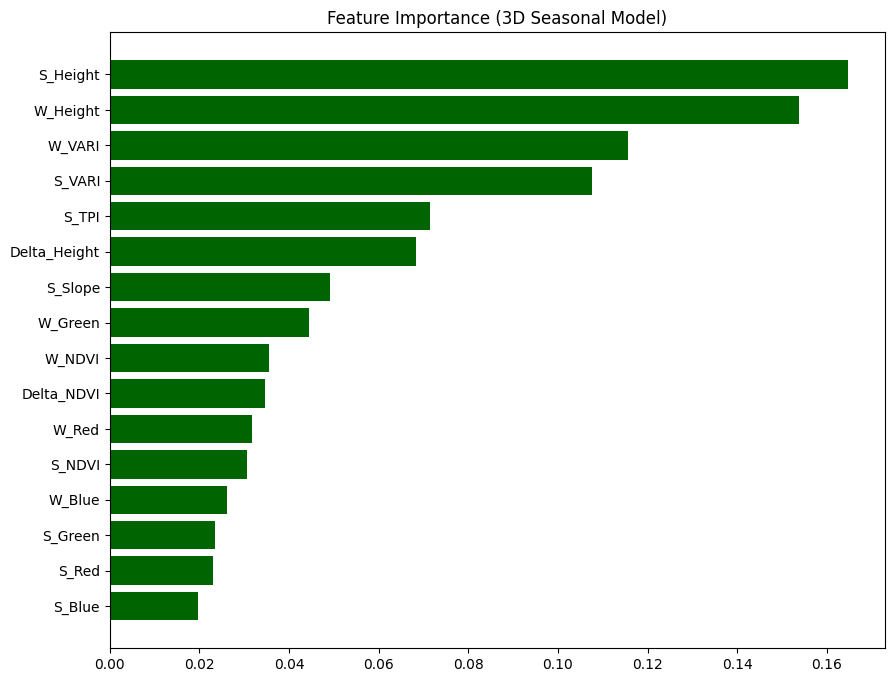

In [47]:
importances = rf.feature_importances_
feature_names = [
    'S_Red', 'S_Green', 'S_Blue', 'W_Red', 'W_Green', 'W_Blue',
    'S_NDVI', 'W_NDVI', 'S_VARI', 'W_VARI', 'Delta_NDVI',
    'S_Height', 'W_Height', 'Delta_Height',
    'S_Slope', 'S_TPI', 'Rel_Elev'
]
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('Feature Importance (3D Seasonal Model)')
plt.barh(range(len(indices)), importances[indices], color='darkgreen', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()